In [1]:
# load libraries 

import numpy as np, pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score,roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt

In [2]:
# set seeds
torch.manual_seed(2020)
np.random.seed(2020)

In [3]:
# load data
train = np.loadtxt("ECG200_TRAIN.txt")
test  = np.loadtxt("ECG200_TEST.txt")

# the first column is label
X_train = train[:, 1:]       
y_train = train[:, 0].astype(int)     
X_test  = test[:, 1:]              
y_test  = test[:, 0].astype(int)

# original label is -1, +1, we convert to 0, 1 for BCE
y_train = (y_train == 1).astype(np.float32)
y_test  = (y_test == 1).astype(np.float32)


# convert to torch tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # (N,1)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


print("X_train:", X_train.shape, "y_train:", y_train.shape)

X_train: torch.Size([100, 96]) y_train: torch.Size([100, 1])


In [4]:
# define a baseline NeuralNetwork

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(96, 256)
        self.relu1 = nn.ReLU()
        
        self.out = nn.Linear(256, 1)
        self.final = nn.Sigmoid()

    def forward(self, x):
        
        op = self.fc1(x)
        op = self.relu1(op)
        
        op = self.out(op)
        y = self.final(op)

        return y                       


def predict(model,x_test,y_test):
    y_test_pred = model(x_test)
    a =np.where(y_test_pred>0.5,1,0)
    return sum(a == y_test.numpy())/len(y_test)

In [5]:
#Define function to train the network
def train_network(model,optimizer,loss_function,num_epochs,batch_size,X_train,Y_train,lambda_L1=0.0):
    loss_across_epochs = []
    for epoch in range(num_epochs):
        train_loss= 0.0
        #Explicitly start model training
        model.train()
        for i in range(0,X_train.shape[0],batch_size):
            #Extract train batch from X and Y
            input_data = X_train[i:min(X_train.shape[0],i+batch_size)]
            labels = Y_train[i:min(X_train.shape[0],i+batch_size)]
            #set the gradients to zero before starting to do backpropragation
            optimizer.zero_grad()
            #Forward pass
            output_data  = model(input_data)
            #Caculate loss
            loss = loss_function(output_data, labels)
            L1_loss = 0
            #Compute L1 penalty to be added with loss
            for p in model.parameters():
                L1_loss = L1_loss + p.abs().sum()
            #Add L1 penalty to loss
            loss = loss + lambda_L1 * L1_loss
            #Backpropogate
            loss.backward()
            #Update weights
            optimizer.step()
            train_loss += loss.item() * input_data.size(0)
        loss_across_epochs.append(train_loss/X_train.size(0))
        if epoch%10 == 0:
            print("Epoch: {} - Loss:{:.4f}".format(epoch,train_loss/X_train.size(0) ))
    return(loss_across_epochs)

In [6]:
#Define function for evaluating NN
def evaluate_model(model,x_test,y_test,X_train,Y_train,loss_list):
    model.eval() #Explicitly set to evaluate mode
    #Predict on Train and Validation Datasets
    y_test_prob = model(x_test)
    y_test_pred =np.where(y_test_prob>0.5,1,0)
    Y_train_prob = model(X_train)
    Y_train_pred =np.where(Y_train_prob>0.5,1,0)
    #Compute Training and Validation Metrics
    print("\n Model Performance -")
    print("Training Accuracy-",round(accuracy_score(Y_train,Y_train_pred),3))
    print("Training Precision-",round(precision_score(Y_train,Y_train_pred),3))
    print("Training Recall-",round(recall_score(Y_train,Y_train_pred),3))
    print("Training ROCAUC", round(roc_auc_score(Y_train
                                   ,Y_train_prob.detach().numpy()),3))
    print("Validation Accuracy-",round(accuracy_score(y_test,y_test_pred),3))
    print("Validation Precision-",round(precision_score(y_test,y_test_pred),3))
    print("Validation Recall-",round(recall_score(y_test,y_test_pred),3))
    print("Validation ROCAUC", round(roc_auc_score(y_test
                                     ,y_test_prob.detach().numpy()),3))
    print("\n")
    #Plot the Loss curve and ROC Curve
    plt.figure(figsize=(20,5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_list)
    plt.title('Loss across epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.subplot(1, 2, 2)
    #Validation
    fpr_v, tpr_v, _ = roc_curve(y_test, y_test_prob.detach().numpy())
    roc_auc_v = auc(fpr_v, tpr_v)
    #Training
    fpr_t, tpr_t, _ = roc_curve(Y_train, Y_train_prob.detach().numpy())
    roc_auc_t = auc(fpr_t, tpr_t)
    plt.title('Receiver Operating Characteristic:Validation')
    plt.plot(fpr_v, tpr_v, 'b', label = 'Validation AUC = %0.2f' % roc_auc_v)
    plt.plot(fpr_t, tpr_t, 'r', label = 'Training AUC = %0.2f' % roc_auc_t)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Epoch: 0 - Loss:0.5972
Epoch: 10 - Loss:0.2306
Epoch: 20 - Loss:0.1455
Epoch: 30 - Loss:0.0896
Epoch: 40 - Loss:0.0551
Epoch: 50 - Loss:0.0352
Epoch: 60 - Loss:0.0234
Epoch: 70 - Loss:0.0163
Epoch: 80 - Loss:0.0119
Epoch: 90 - Loss:0.0090
Epoch: 100 - Loss:0.0070
Epoch: 110 - Loss:0.0055
Epoch: 120 - Loss:0.0045
Epoch: 130 - Loss:0.0037
Epoch: 140 - Loss:0.0031
Epoch: 150 - Loss:0.0026
Epoch: 160 - Loss:0.0022
Epoch: 170 - Loss:0.0019
Epoch: 180 - Loss:0.0017
Epoch: 190 - Loss:0.0015
Epoch: 200 - Loss:0.0013
Epoch: 210 - Loss:0.0012
Epoch: 220 - Loss:0.0010
Epoch: 230 - Loss:0.0009
Epoch: 240 - Loss:0.0008
Epoch: 250 - Loss:0.0008
Epoch: 260 - Loss:0.0007
Epoch: 270 - Loss:0.0006
Epoch: 280 - Loss:0.0006
Epoch: 290 - Loss:0.0005

 Model Performance -
Training Accuracy- 1.0
Training Precision- 1.0
Training Recall- 1.0
Training ROCAUC 1.0
Validation Accuracy- 0.9
Validation Precision- 0.909
Validation Recall- 0.938
Validation ROCAUC 0.954




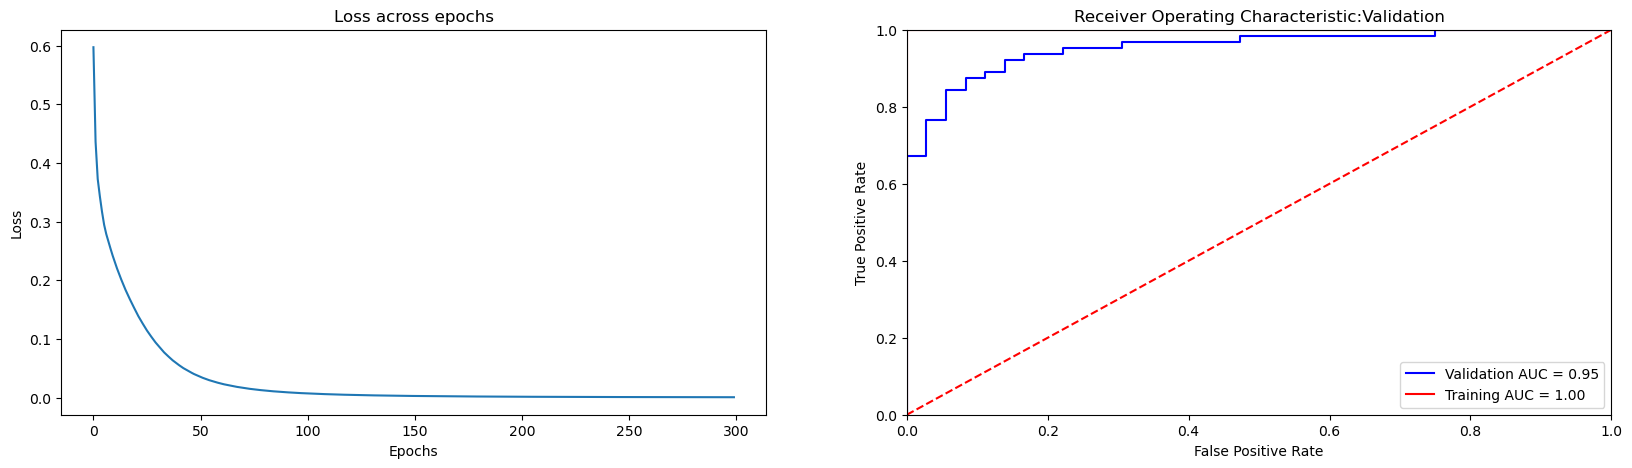

In [7]:

num_epochs = 200
batch_size= 16
loss_function = nn.BCELoss()  #Binary Crosss Entropy Loss
#Hyperparameters
weight_decay=0.0 #set to 0; no L2 Regularizer; passed into the Optimizer
lambda_L1=0.0    #Set to 0; no L1 reg; manually added in loss (train_network)
#Create a model instance
model = NeuralNetwork()
#Define optimizer
adam_optimizer = torch.optim.Adam(model.parameters(), lr= 0.001,weight_decay=weight_decay)
#Train model
adam_loss = train_network(model,adam_optimizer,loss_function,num_epochs,batch_size,X_train,y_train,lambda_L1=0.0)
#Evaluate model
evaluate_model(model,X_test,y_test,X_train,y_train,adam_loss)
